In [1]:
import numpy as np
import random
import sys
from collections import defaultdict
from copy import deepcopy
import scipy
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from tqdm import trange

from helpers.helpers import plot_result, save_string_fn
from api.instance import Instance
from approaches.local_search_cycle.local_search_heuristic import LocalSearch
from approaches.random_cycle.random_heuristic import Random
from api.replacement import Replacement

In [2]:
class Results():
    def __init__(self, cost, similar_to_best, similar_to_others, me = False):
        self.cost = cost
        self.similar_to_best = similar_to_best 
        self.similar_to_others = similar_to_others
        self.me = me
    
    def __str__(self):
        return f'Results(cost={self.cost}, similar_to_best={self.similar_to_best}, similar_to_others={self.similar_to_others}, me={self.me})'
    def __repr__(self):
        return self.__str__()

In [3]:
def compute(instance, nums):
    solutions = []
    t = trange(nums, desc=instance_name, leave=True)
    for local_number in t:
        first_start_node = random.choice( list(instance.point_dict.keys()) )
        second_start_node = random.choice( list( set(list(instance.point_dict.keys())) - set([first_start_node]) ) )

        random_cycle = Random(instance, seed = None)
        random_cycle.solve(first_start_node, second_start_node)

        ##################################################################
        #Local Search
        local_search = LocalSearch(instance)
        local_search.neighborhood = 'edges' 

        #steepest, edges, random
        local_search.first_solution = random_cycle.first_solution[:]
        local_search.second_solution = random_cycle.second_solution[:]
        time = local_search.solve(method = 'greedy')
        #print(f'\r->  Local iteration number: {local_number+1}, time = {np.round(time, 2)}', end='')
        
        r = Replacement(local_search.first_solution[:], local_search.second_solution[:], local_search.compute_total_cost())
        solutions.append( r )
    print()
    return solutions

In [4]:
def find_num_of_common_nodes(sol1, sol2):
    x1 = len( set(sol1.first_cycle) & set(sol2.first_cycle) )
    x2 = len( set(sol1.first_cycle) & set(sol2.second_cycle) )
    if x1 > x2:
        x2 = len( set(sol1.second_cycle) & set(sol2.second_cycle) )
    else:
        x1 = len( set(sol1.second_cycle) & set(sol2.first_cycle) )
    return (x1 + x2) / (len(sol2.first_cycle + sol2.second_cycle) - 2)

def get_edges(sol):
    sol_edges1 = [ frozenset((sol.first_cycle[i], sol.first_cycle[i+1])) for i in range(len(sol.first_cycle) - 1) ]
    sol_edges2 = [ frozenset((sol.second_cycle[i], sol.second_cycle[i+1])) for i in range(len(sol.second_cycle) - 1) ]
    return sol_edges1, sol_edges2

def find_num_of_common_edges(sol1_edges1, sol1_edges2, sol2):
    sol2_edges1, sol2_edges2 = get_edges(sol2)
    
    x1 = len( set(sol1_edges1) & set(sol2_edges1) )
    x2 = len( set(sol1_edges1) & set(sol2_edges2) )
    if x1 > x2:
        x2 = len( set(sol1_edges2) & set(sol2_edges2) )
    else:
        x1 = len( set(sol1_edges2) & set(sol2_edges1) )
    return (x1 + x2) / (len(sol2.first_cycle + sol2.second_cycle) - 2)
        

In [5]:
def compare(solutions):
    compare_nodes = list()
    compare_edges = list()
    
    best_idx = np.argmin(solutions)
    best = solutions[best_idx]
    sol1_edges1_best, sol1_edges2_best = get_edges(best)
    
    for idx, sol in enumerate(solutions):
        me = False
        sol1_edges1, sol1_edges2 = get_edges(sol)
        temp1 = list()
        temp2 = list()
        for idx2, sol2 in enumerate(solutions):
            if idx == idx2:
                continue
            temp1.append( find_num_of_common_nodes(sol, sol2) )
            temp2.append( find_num_of_common_edges(sol1_edges1, sol1_edges2, sol2) )
        if idx == best_idx:
            me = True
        compare_nodes.append(Results(sol.score, find_num_of_common_nodes(best, sol), np.mean(temp1), me))
        compare_edges.append(Results(sol.score, find_num_of_common_edges(sol1_edges1_best, sol1_edges2_best, sol),
                                     np.mean(temp2), me))
    return compare_nodes, compare_edges
        
    

In [6]:
def plot_comparison(compare_nodes, compare_edges):
    
    result_edges = [[edge.cost, edge.similar_to_best] for edge in compare_edges if not edge.me]
    result_nodes = [[node.cost, node.similar_to_best] for node in compare_nodes if not node.me]
    
    np_edge = np.asarray(result_edges)
    np_vertex = np.asarray(result_nodes)
    
    corr_edge, _ = scipy.stats.pearsonr(np_edge[:, 0], np_edge[:, 1])
    corr_vertex, _ = scipy.stats.pearsonr(np_vertex[:, 0], np_vertex[:, 1])

    df_edge = pd.DataFrame({'Koszt': np_edge[:, 0], 'Podobieństwo krawędzi': np_edge[:, 1]})
    df_vertex = pd.DataFrame({'Koszt': np_vertex[:, 0], 'Podobieństwo wierzchołków': np_vertex[:, 1]})


    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    fig, ax =plt.subplots(1,2,figsize=(12,6))

    sns.scatterplot(data=df_edge, x='Koszt',y='Podobieństwo krawędzi',ax=ax[0])
    sns.scatterplot(data=df_vertex, x='Koszt',y='Podobieństwo wierzchołków',ax=ax[1])
    ax[0].set_title(f'Korelacja {round(corr_edge,2)}')
    ax[1].set_title(f'Korelacja {round(corr_vertex,2)}')
    ax[1].yaxis.set_label_position("right")


    plt.suptitle(f'{instance_name}, podobieństwo do najlepszego rozwiązania')
    plt.savefig(os.path.join('pictures', 'Convex', f'{instance_name}_best.png'))
    
    
    
    result_edges = [[edge.cost, edge.similar_to_others] for edge in compare_edges]
    result_nodes = [[node.cost, node.similar_to_others] for node in compare_nodes]
    
    np_edge = np.asarray(result_edges)
    np_vertex = np.asarray(result_nodes)
    
    corr_edge, _ = scipy.stats.pearsonr(np_edge[:, 0], np_edge[:, 1])
    corr_vertex, _ = scipy.stats.pearsonr(np_vertex[:, 0], np_vertex[:, 1])

    df_edge = pd.DataFrame({'Koszt': np_edge[:, 0], 'Podobieństwo krawędzi': np_edge[:, 1]})
    df_vertex = pd.DataFrame({'Koszt': np_vertex[:, 0], 'Podobieństwo wierzchołków': np_vertex[:, 1]})


    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    fig, ax =plt.subplots(1,2,figsize=(12,6))

    sns.scatterplot(data=df_edge, x='Koszt',y='Podobieństwo krawędzi',ax=ax[0])
    sns.scatterplot(data=df_vertex, x='Koszt',y='Podobieństwo wierzchołków',ax=ax[1])
    ax[0].set_title(f'Korelacja {round(corr_edge,2)}')
    ax[1].set_title(f'Korelacja {round(corr_vertex,2)}')
    ax[1].yaxis.set_label_position("right")


    plt.suptitle(f'{instance_name}, podobieństwo do pozostałych rozwiązań')
    plt.savefig(os.path.join('pictures', 'Convex', f'{instance_name}_all.png'))

    

kroA200: 100%|███████████████████████████████████████████████████████████████████| 1000/1000 [1:18:25<00:00,  4.71s/it]


kroB200: 100%|███████████████████████████████████████████████████████████████████| 1000/1000 [1:16:39<00:00,  4.60s/it]


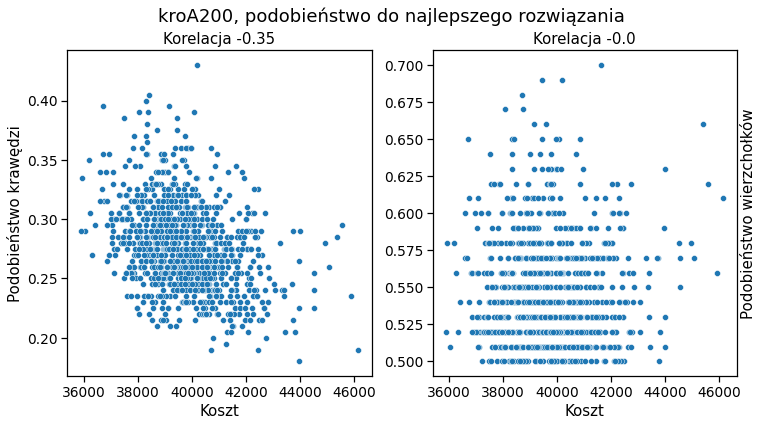

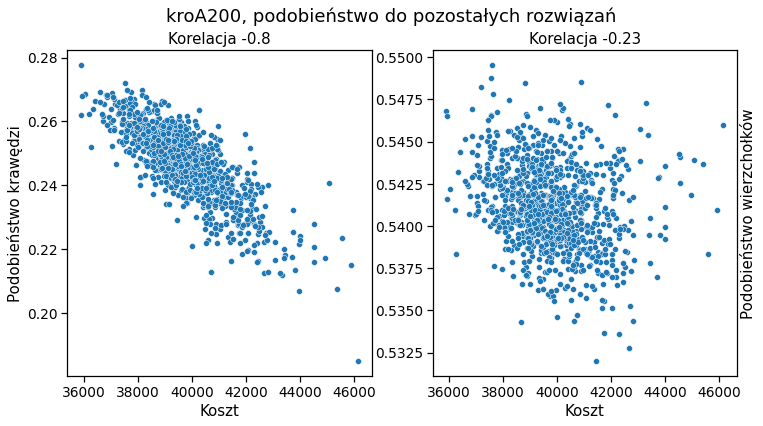

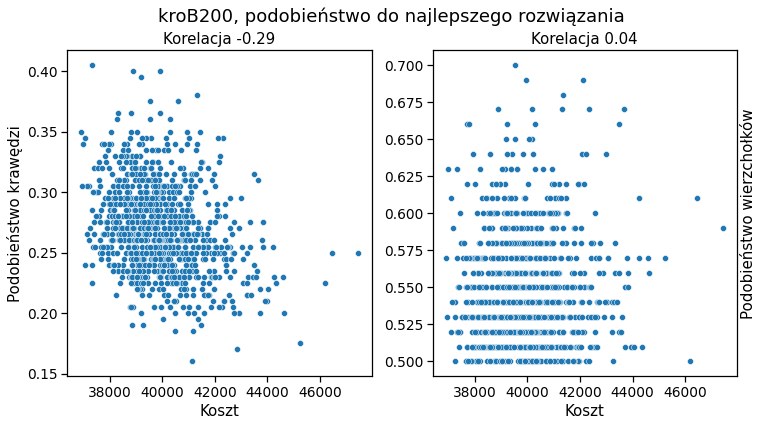

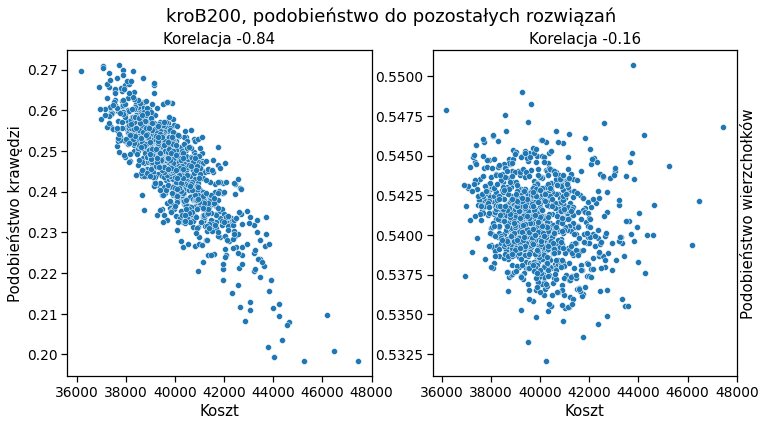

In [7]:
for instance_name in ['kroA200', 'kroB200']:
    instance = Instance(name = instance_name)
    instance.compute_matrix()
    solutions = compute(instance, 1000)
    plot_comparison( *compare(solutions) )
    